In [15]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_model_comparison_plot(file_path, fig_title, save_path):
    # Load data
    df = pl.read_csv(file_path).to_pandas()
    
    # Calculate product of metrics for sorting
    metrics = ['acc', 'f1_macro', 'f1_weighted']
    df['metric_product'] = df[metrics].product(axis=1)

    print(df['metric_product'])
    
    # Sort models
    df['model'] = pd.Categorical(df['model'], 
                               categories=df.sort_values('metric_product', ascending=False)['model'],
                               ordered=True)
    
    print(df)
    
    # Prepare data for plotting
    metrics_df = df.melt(id_vars=['model'], 
                        value_vars=metrics,
                        var_name='Metric', 
                        value_name='Score')
    
    std_df = df.melt(id_vars=['model'], 
                     value_vars=[m + '_std' for m in metrics],
                     value_name='Std')
    
    metrics_df['Std'] = std_df['Std']
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Calculate bar positions
    n_models = len(df['model'].unique())
    n_metrics = len(metrics)
    width = 0.25
    
    x = np.arange(n_models)
    
    # Plot bars and error bars for each metric
    for i, metric in enumerate(metrics):
        mask = metrics_df['Metric'] == metric
        plt.bar(x + i*width, 
               metrics_df[mask]['Score'], 
               width, 
               label=metric,
               color=sns.color_palette('viridis')[i])
        
        plt.errorbar(x + i*width, 
                    metrics_df[mask]['Score'],
                    yerr=metrics_df[mask]['Std'],
                    fmt='none',
                    color='black',
                    alpha=0.5,
                    capsize=3)
    
    plt.title(fig_title)
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(x + width, df['model'], rotation=45)
    plt.legend()
    plt.tight_layout()

    fig = plt.gcf()

    if save_path is not None:
        fig.savefig(save_path)

# Usage
fig = create_model_comparison_plot(
    'logs/mds_disease/mds_disease_mrna.csv',
    'Model performance with only mrna for MDS disease task',
    'plots/mds_disease_mrna.png'
)

FileNotFoundError: No such file or directory (os error 2): logs/mds_disease/mds_disease_mrna.csv

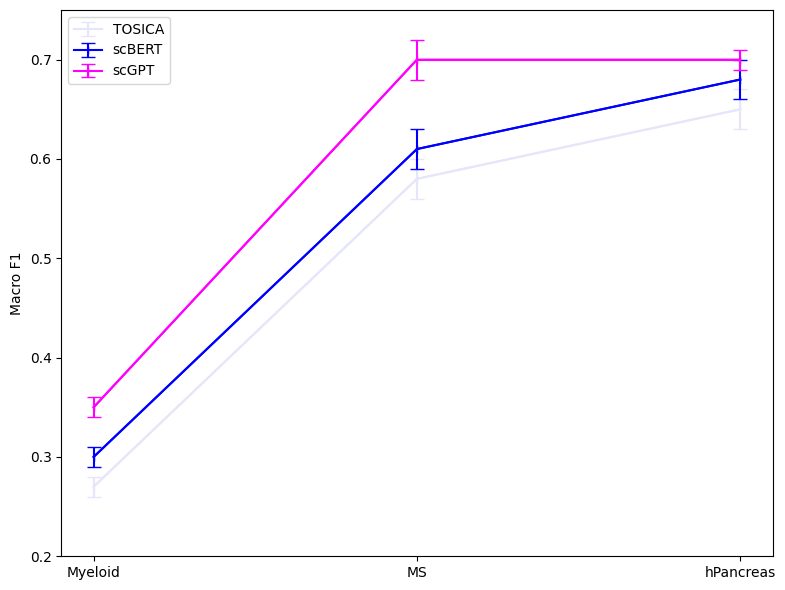

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Myeloid', 'MS', 'hPancreas']
tosica = [0.27, 0.58, 0.65]
scbert = [0.30, 0.61, 0.68]
scgpt = [0.35, 0.70, 0.70]

# Error bars (approximated from the image)
tosica_err = [0.01, 0.02, 0.02]
scbert_err = [0.01, 0.02, 0.02]
scgpt_err = [0.01, 0.02, 0.01]

# Create figure
plt.figure(figsize=(8, 6))

# Plot lines with error bars
plt.errorbar(categories, tosica, yerr=tosica_err, label='TOSICA', color='lavender', marker='|', capsize=5)
plt.errorbar(categories, scbert, yerr=scbert_err, label='scBERT', color='blue', marker='|', capsize=5)
plt.errorbar(categories, scgpt, yerr=scgpt_err, label='scGPT', color='magenta', marker='|', capsize=5)

# Customize plot
plt.ylim(0.2, 0.75)
plt.ylabel('Macro F1')
plt.grid(False)
plt.legend()

# Connect points with lines
for i in range(len(categories)-1):
    plt.plot(categories[i:i+2], tosica[i:i+2], color='lavender')
    plt.plot(categories[i:i+2], scbert[i:i+2], color='blue')
    plt.plot(categories[i:i+2], scgpt[i:i+2], color='magenta')

plt.tight_layout()
plt.show()

0.6713799889931291 1.1133819157687757
0.38985555068327726 1.1625004266727001
0.6666101935689215 1.090016513057785


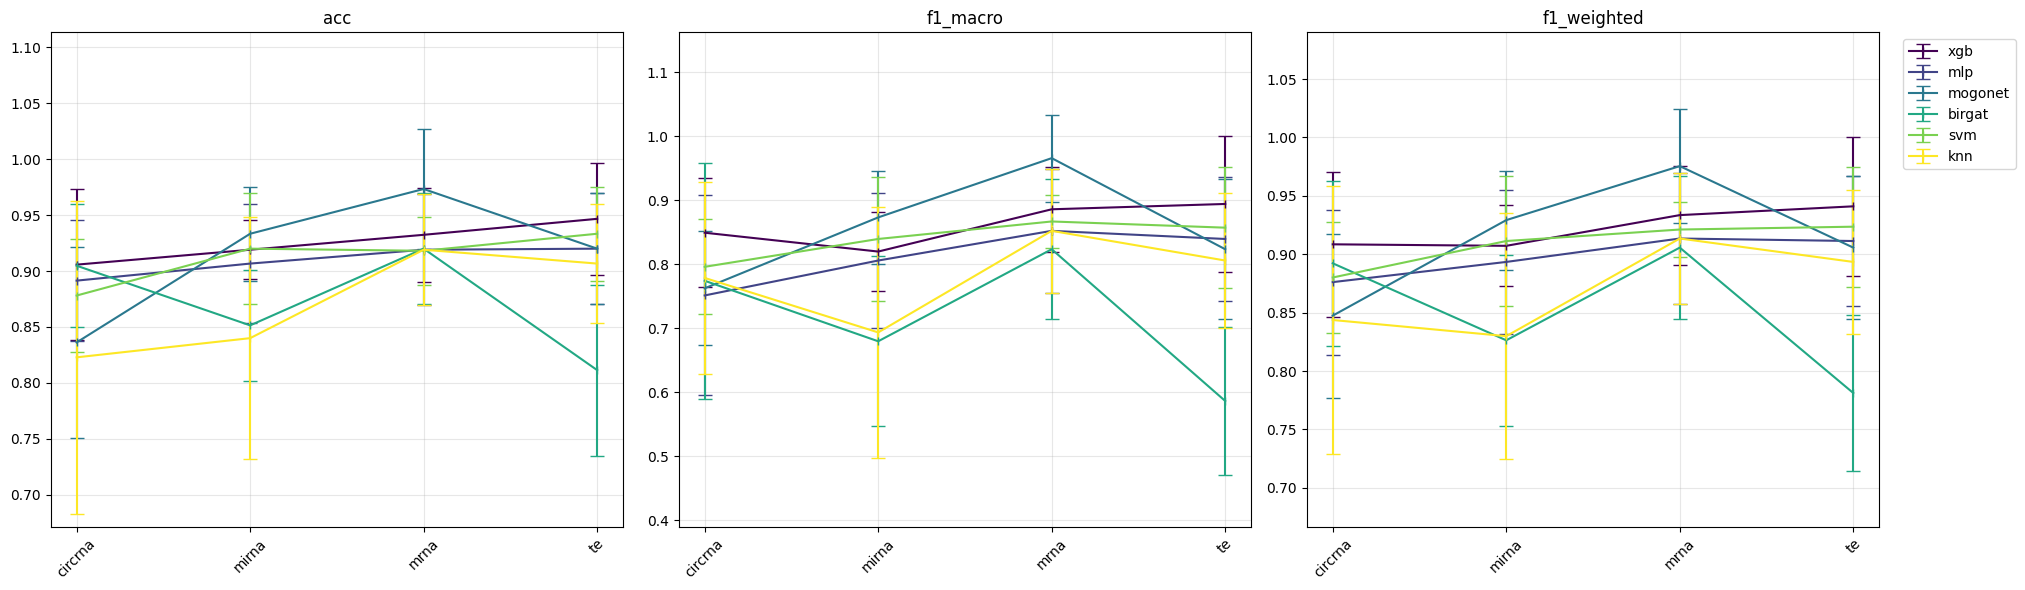

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment_metrics(experiment_files: dict):
    metrics = ['acc', 'f1_macro', 'f1_weighted']
    
    # Process each experiment
    results = {}
    first_df = pl.read_csv(next(iter(experiment_files.values())))
    models = first_df['model'].unique().to_list()
    
    # Store results by experiment and model
    for exp_name, file_path in experiment_files.items():
        df = pl.read_csv(file_path)
        results[exp_name] = {}
        for model in models:
            model_data = df.filter(pl.col('model') == model)
            results[exp_name][model] = {
                'means': model_data.select(pl.col(metrics)).mean().to_numpy().flatten(),
                'stds': model_data.select(pl.col([m + '_std' for m in metrics])).mean().to_numpy().flatten()
            }
    
    # Create a plot for each metric
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.subplots_adjust(wspace=0.3)  # Increase space between subplots

    exp_names = list(results.keys())
    x = np.arange(len(exp_names))
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes)):
        for model_idx, model in enumerate(models):
            metric_values = [results[exp][model]['means'][idx] for exp in exp_names]
            metric_errors = [results[exp][model]['stds'][idx] for exp in exp_names]
            
            # Plot error bars and line
            ax.errorbar(x, metric_values, yerr=metric_errors,
                       fmt='-', marker='|', capsize=5, label=model,
                       color=colors[model_idx])
        
        ax.set_xticks(x)
        ax.set_xticklabels(exp_names, rotation=45)
        ax.set_title(metric)
        ax.grid(True, alpha=0.3)  # Add light grid
        
        # Set y-axis limits with padding
        all_values = [results[exp][model]['means'][idx] for exp in exp_names for model in models]
        all_errors = [results[exp][model]['stds'][idx] for exp in exp_names for model in models]

        ymin = min(all_values) - max(all_errors)
        ymax = max(all_values) + max(all_errors)
        print(ymin, ymax)
        
        ax.set_ylim(ymin, ymax)
        
        # if idx == 0:  # Only show legend on first plot
        #     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        
    ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right')  # Changed from 1.05 to 1.4
    
    plt.tight_layout()
    return fig

experiment_files = {
    'circrna': 'logs/mds_disease/mds_disease_circrna.csv',
    'mirna': 'logs/mds_disease/mds_disease_mirna.csv',
    'mrna': 'logs/mds_disease/mds_disease_mrna.csv',
    'te': 'logs/mds_disease/mds_disease_te.csv'
}

fig = plot_experiment_metrics(experiment_files)
plt.show()

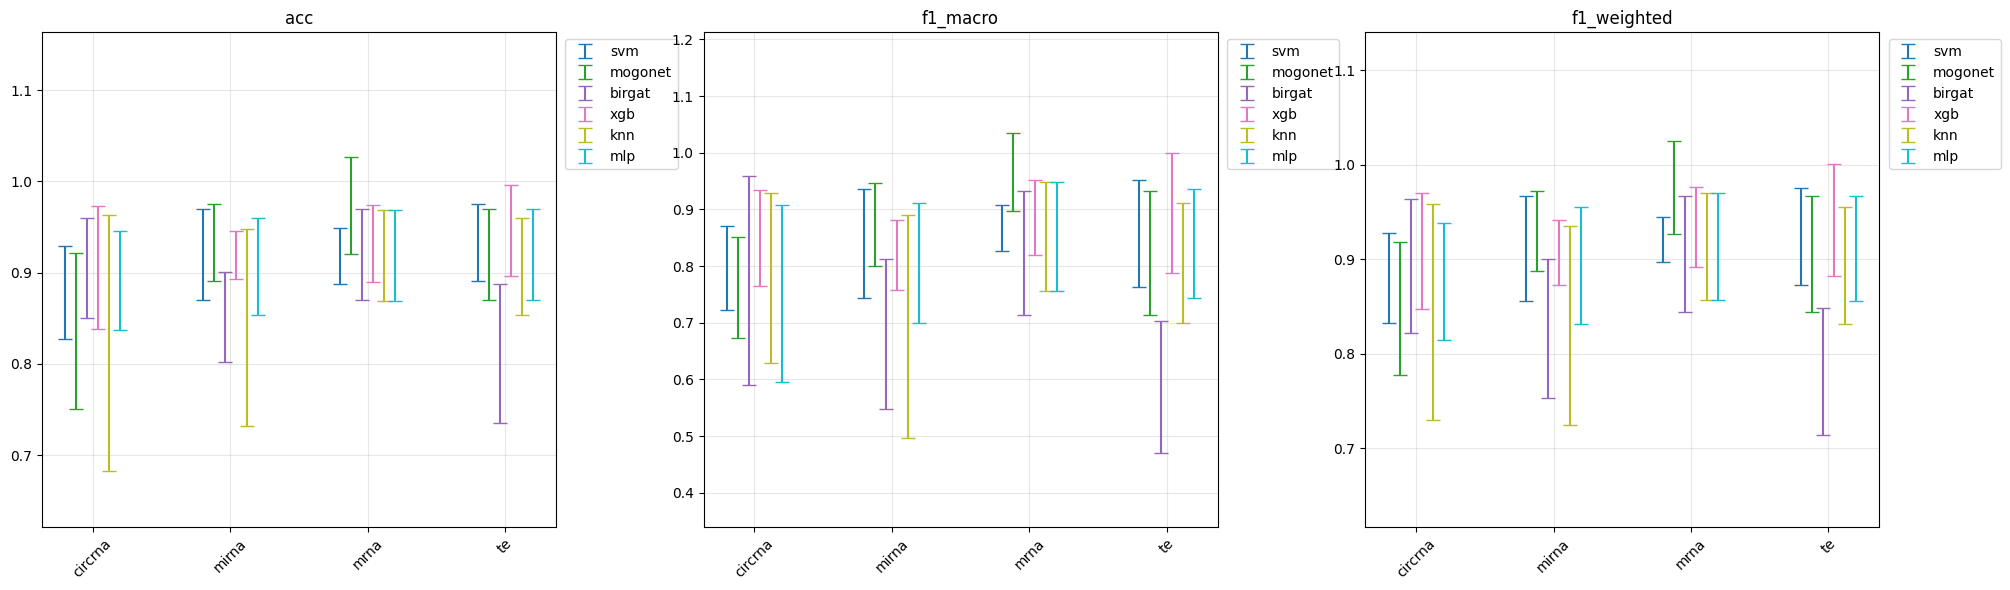

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment_metrics(experiment_files: dict, show_lines: bool = False):
    metrics = ['acc', 'f1_macro', 'f1_weighted']
    results = {}
    first_df = pl.read_csv(next(iter(experiment_files.values())))
    models = first_df['model'].unique().to_list()
    
    for exp_name, file_path in experiment_files.items():
        df = pl.read_csv(file_path)
        results[exp_name] = {}
        for model in models:
            model_data = df.filter(pl.col('model') == model)
            results[exp_name][model] = {
                'means': model_data.select(pl.col(metrics)).mean().to_numpy().flatten(),
                'stds': model_data.select(pl.col([m + '_std' for m in metrics])).mean().to_numpy().flatten()
            }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.subplots_adjust(wspace=0.3)
    
    exp_names = list(results.keys())
    x = np.arange(len(exp_names))
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    markers = ['o', 's', 'D', '^', 'v', 'p']
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes)):
        offset = np.linspace(-0.2, 0.2, len(models))
        
        for model_idx, model in enumerate(models):
            metric_values = [results[exp][model]['means'][idx] for exp in exp_names]
            metric_errors = [results[exp][model]['stds'][idx] for exp in exp_names]
            
            linestyle = '-' if show_lines else 'none'
            ax.errorbar(x + offset[model_idx], 
                       metric_values, yerr=metric_errors,
                       fmt=linestyle, marker=markers[model_idx], 
                       markersize=8, capsize=5,
                       label=model, color=colors[model_idx])
            
        ax.set_xticks(x)
        ax.set_xticklabels(exp_names, rotation=45)
        ax.set_title(metric)
        ax.grid(True, alpha=0.3)
        
        all_values = [results[exp][model]['means'][idx] for exp in exp_names for model in models]
        all_errors = [results[exp][model]['stds'][idx] for exp in exp_names for model in models]
        ymin = min(all_values) - max(all_errors) - 0.05
        ymax = max(all_values) + max(all_errors) + 0.05
        ax.set_ylim(ymin, ymax)
        
        ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    
    plt.tight_layout()
    return fig

# Usage:
experiment_files = {
    'circrna': 'logs/mds_disease/mds_disease_circrna.csv',
    'mirna': 'logs/mds_disease/mds_disease_mirna.csv',
    'mrna': 'logs/mds_disease/mds_disease_mrna.csv',
    'te': 'logs/mds_disease/mds_disease_te.csv'
}

# Set show_lines=True to show connecting linesout
fig = plot_experiment_metrics(experiment_files, show_lines=False)
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

from src.plotting.plotting import plot_experiment_metrics
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


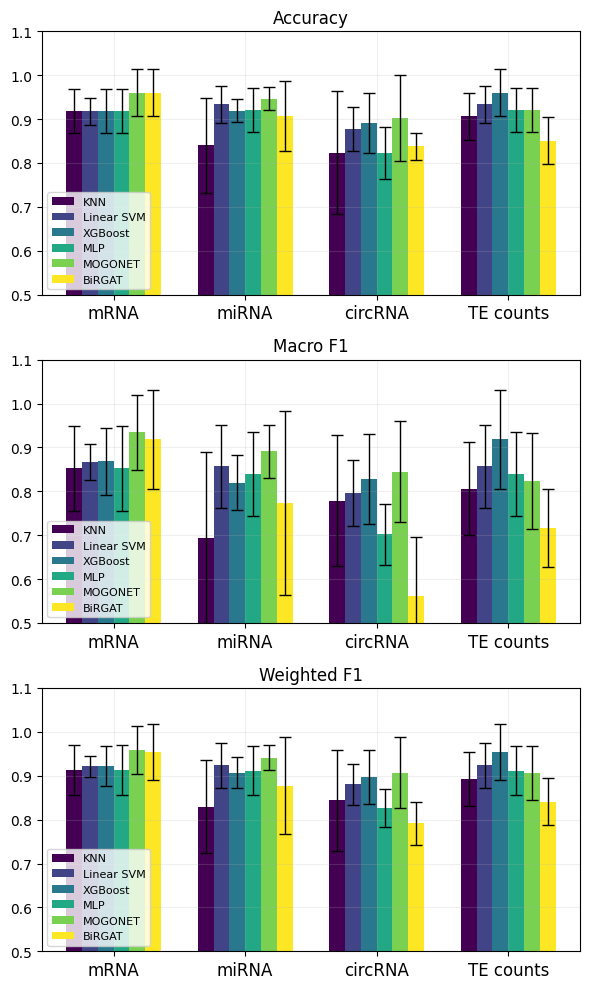

In [71]:
experiment_files = {
    'mRNA': 'logs/mds_disease/mrna.csv',
    'miRNA': 'logs/mds_disease/mirna.csv',
    'circRNA': 'logs/mds_disease/circrna.csv',
    'TE counts': 'logs/mds_disease/te.csv'
}

fig = plot_experiment_metrics(experiment_files, save_file="plots/mrna_disease_single_omic_result.png")
plt.show()

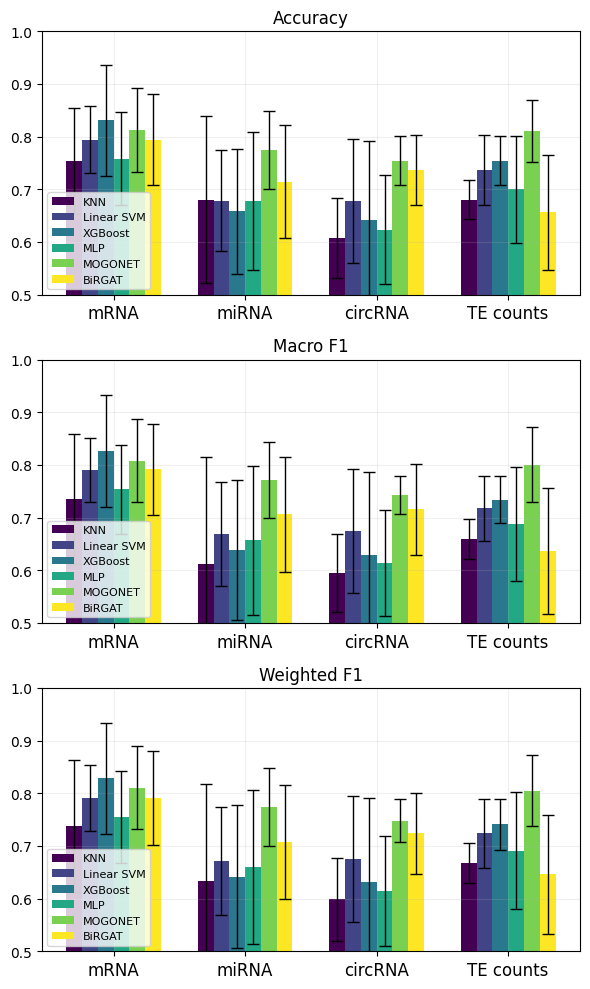

In [73]:
experiment_files = {
    'mRNA': 'logs/mds_risk/mrna.csv',
    'miRNA': 'logs/mds_risk/mirna.csv',
    'circRNA': 'logs/mds_risk/circrna.csv',
    'TE counts': 'logs/mds_risk/te.csv'
}

fig = plot_experiment_metrics(experiment_files, save_file="plots/mrna_risk_single_omic_result.png")
plt.show()

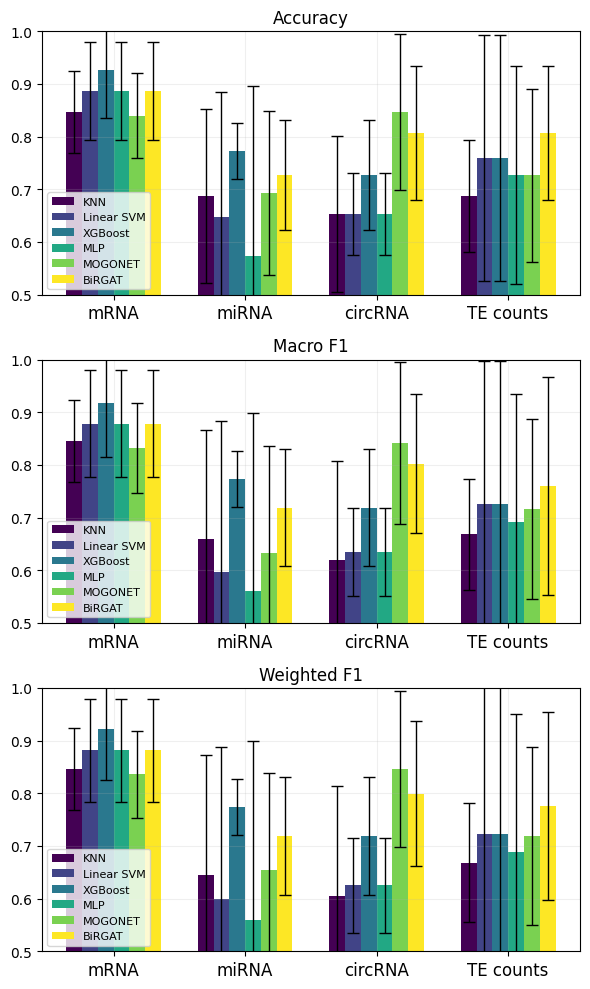

In [74]:
experiment_files = {
    'mRNA': 'logs/mds_mutation/mrna.csv',
    'miRNA': 'logs/mds_mutation/mirna.csv',
    'circRNA': 'logs/mds_mutation/circrna.csv',
    'TE counts': 'logs/mds_mutation/te.csv'
}

fig = plot_experiment_metrics(experiment_files, save_file="plots/mrna_mutation_single_omic_result.png")
plt.show()